In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import os
import datetime
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [100]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [101]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]
#     )
#   except RuntimeError as e:
#     print(e)

# devices = tf.config.list_physical_devices()
# print("Available devices:\n", devices)

# tf.config.set_visible_devices(gpus[0], "GPU")

# logical_gpus = tf.config.experimental.list_logical_devices("GPU")
# print("Using GPU:", logical_gpus[0].name)

## learnt that psi_e,psi_p,mov_avg3,U_autocorr doesnt play much role in the training process and its mostly the rolling_R, mov_avg,mov_avg2

In [102]:
data = pd.read_csv('./data/train_data_subsampled_autocorr1.csv')

y = data['R']
# X = data.drop(['R','mov_avg','mov_avg2', 'mov_avg3', 'U_autocorr'], axis=1)
X = data.drop(['R'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [103]:
print("X_test:",X_test.shape)
print("X_train:",X_train.shape)

X_test: (492, 5)
X_train: (1966, 5)


In [104]:
# X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))
# y_train = y_train.to_numpy().reshape((y_train.shape[0], 1, 1))
# y_test = y_test.to_numpy().reshape((y_test.shape[0], 1, 1))

# input_dim = 5
# hidden_size = 5
# output_size = 1

# model = keras.Sequential([
#     keras.layers.LSTM(hidden_size, return_sequences=True, input_shape=(None, input_dim), activation='tanh', recurrent_activation='sigmoid'),
#     keras.layers.Dropout(0.2),
#     keras.layers.LSTM(hidden_size, activation='tanh', recurrent_activation='sigmoid'),
#     keras.layers.Dense(output_size, activation='linear')
# ])

# y_test_2d = y_test.reshape(y_test.shape[0], -1)
# x_test_2d = X_test.reshape(X_test.shape[0], -1)

In [105]:
# # Load previously trained model
# model = tf.keras.models.load_model('saved_models/Uautocorr_longtime')

In [106]:
model = keras.Sequential([
    keras.layers.Dense(60, activation='tanh', input_shape=(5,), kernel_initializer='glorot_normal'),
    keras.layers.Dropout(0.1),
    keras.layers.Normalization(),
    keras.layers.Dense(30, activation='tanh', kernel_initializer='glorot_normal'),
    keras.layers.Dropout(0.1),
    keras.layers.Normalization(),
    keras.layers.Dense(20, activation='tanh', kernel_initializer='glorot_normal'),
    keras.layers.Normalization(),
    keras.layers.Dense(10, activation='tanh', kernel_initializer='glorot_normal'),
    keras.layers.Normalization(),
    keras.layers.Dense(1)
])

In [107]:
# model = keras.Sequential([
#     keras.layers.Normalization(),
#     keras.layers.Dense(120, activation='relu', input_shape=(1,)),
#     keras.layers.Dropout(0.2),
#     keras.layers.Normalization(),
#     keras.layers.Dense(60, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.Normalization(),
#     keras.layers.Dense(60, activation='relu'),
#     keras.layers.Normalization(),
#     keras.layers.Dense(30, activation='relu'),
#     keras.layers.Normalization(),
#     keras.layers.Dense(1, activation='relu')
# ])

In [108]:
# model = keras.Sequential([
#     keras.layers.Dense(7, activation='tanh', input_shape=(7,), kernel_initializer='glorot_normal'),
#     keras.layers.Dropout(rate=0.2),
#     keras.layers.Dense(3, activation='tanh', kernel_initializer='glorot_normal'),
#     keras.layers.Dense(1)
# ])

# Create the optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)


# Compile the model
model.compile(optimizer=optimizer, loss='mse')

# Train the model
epochs = 500  # Number of training iterations
batch_size = 128  # Number of samples per gradient update

# Create a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=10, min_lr=0.005)

# Create an early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, mode="min", restore_best_weights=True)

#Create a csv logger
csv_logger = tf.keras.callbacks.CSVLogger('training.log')

# Add the scheduler to the callbacks list
callbacks = [lr_scheduler, early_stopping_callback]

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks, validation_split=0.2)

Epoch 1/500


13/13 [==============================] - 1s 11ms/step - loss: 0.0061 - val_loss: 0.0011 - lr: 1.0000e-04
Epoch 2/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 6.5044e-04 - lr: 1.0000e-04
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 5.4152e-04 - lr: 1.0000e-04
Epoch 4/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 4.7888e-04 - lr: 1.0000e-04
Epoch 5/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 4.6772e-04 - lr: 1.0000e-04
Epoch 6/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 4.3880e-04 - lr: 1.0000e-04
Epoch 7/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 4.3072e-04 - lr: 1.0000e-04
Epoch 8/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 4.2459e-04 - lr: 1.0000e-04
Epoch 9/500
13/13 [==============================] - 0s

In [109]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

# Make predictions using the trained model
predictions = model.predict(X_test)

16/16 [==============================] - 0s 771us/step - loss: 1.1012e-04
Test loss: 0.00011011787137249485
16/16 [==============================] - 0s 584us/step


In [110]:
# # # Save the model
# model.save("saved_models/Uautocorr_longtime")

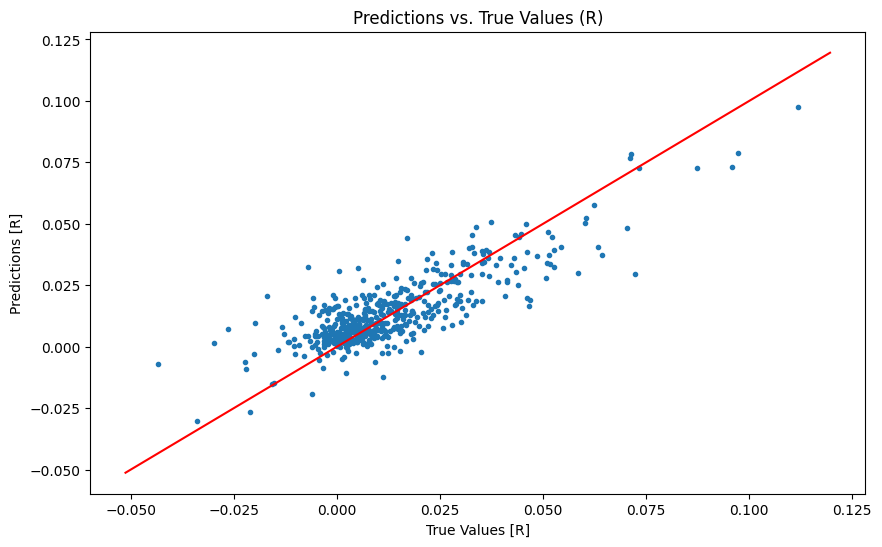

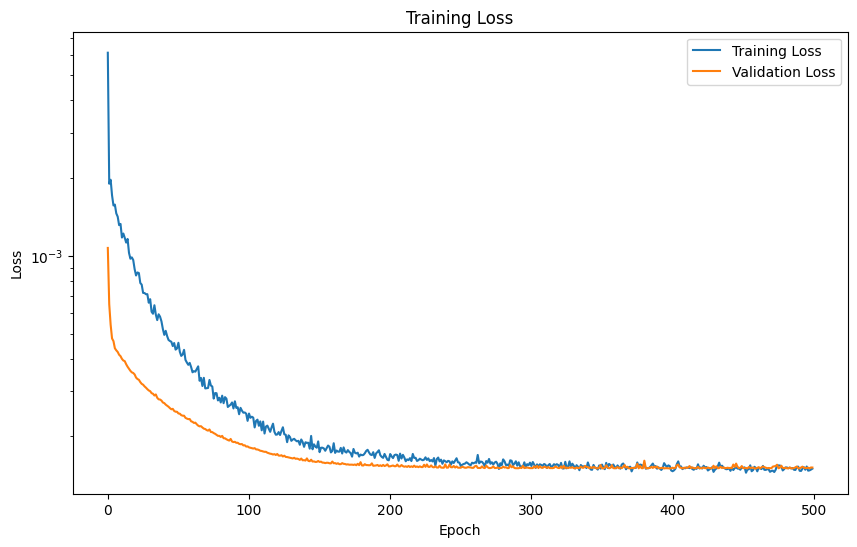

In [111]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(pd.DataFrame(y_test).iloc[:,0], predictions, '.')
# plt.plot(y_test_2d, predictions, '.')
plt.xlabel('True Values [R]')
plt.ylabel('Predictions [R]')
plt.title('Predictions vs. True Values (R)')
# Make a 45 degree line in the same scale and range
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x,'-', color='red')

# Plot the loss vs. epochs
plt.figure(figsize=(10, 6))
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

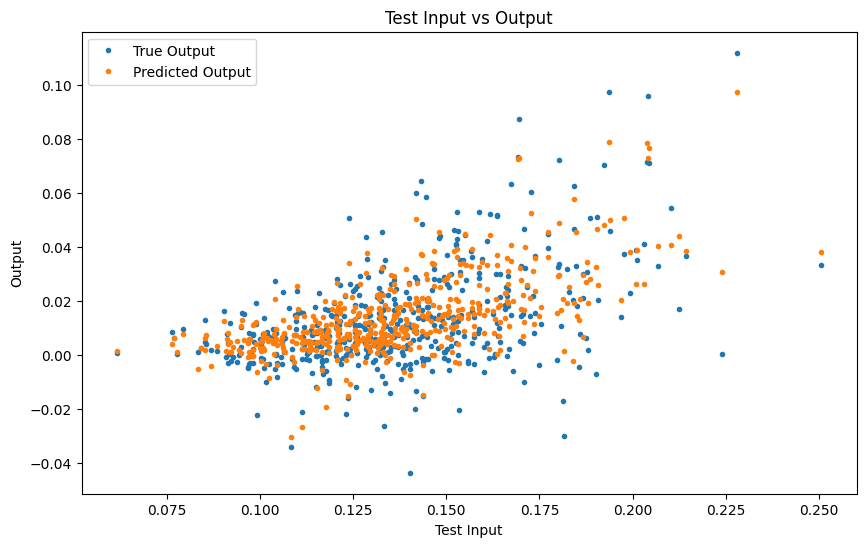

In [112]:
plt.figure(figsize=(10, 6))
#Plot the true output and the predicted output
plt.plot(pd.DataFrame(X_test).iloc[:,0], pd.DataFrame(y_test).iloc[:,0],'.', label='True Output')
plt.plot(pd.DataFrame(X_test).iloc[:,0], predictions,'.', label='Predicted Output')
# plt.plot(x_test_2d[:,0], y_test_2d,'.', label='True Output')
# plt.plot(x_test_2d[:,0], predictions,'.', label='Predicted Output')

plt.xlabel('Test Input')
plt.ylabel('Output')
plt.title('Test Input vs Output')
plt.legend()
plt.show()


In [114]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


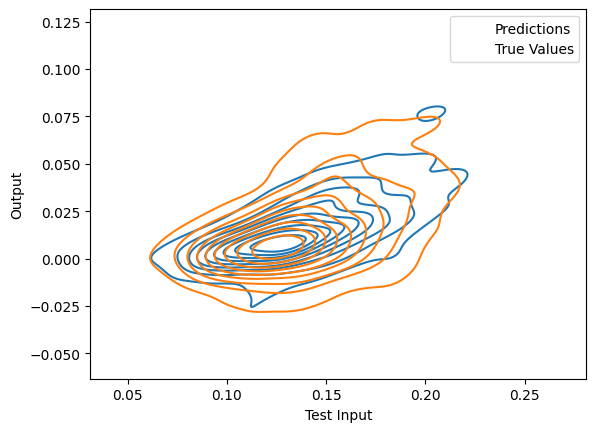

In [120]:
import seaborn as sns

sns.kdeplot(x=pd.DataFrame(X_test).iloc[:,0], y=predictions[:,0], label="Predictions")
sns.kdeplot(x=pd.DataFrame(X_test).iloc[:,0], y=pd.DataFrame(y_test).iloc[:,0], label="True Values")
plt.xlabel('Test Input')
plt.ylabel('Output')
plt.legend()

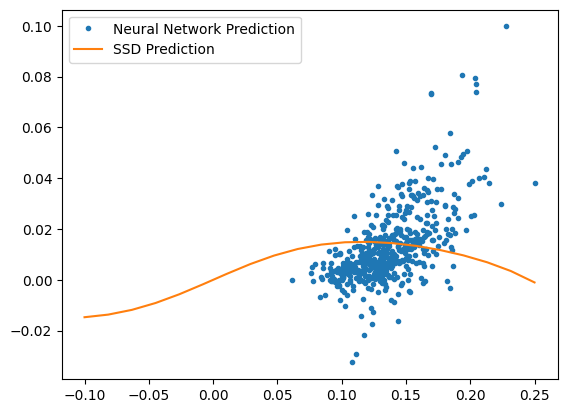

In [98]:
with open("./variables.pickle", "rb") as f:
    R_space, U_space = pickle.load(f)
    
# plt.plot(test_input[sorted_indices], predictions[sorted_indices], label='Neural Network Prediction')
plt.plot(pd.DataFrame(X_test).iloc[:,0], predictions,'.', label='Neural Network Prediction')
plt.plot(U_space, R_space, label='SSD Prediction')
#plt.ylim(0, 0.02)
plt.legend()
plt.show()

In [15]:
# import seaborn as sns

# # Plot the scatter plot with a regression line
# sns.regplot(x=pd.DataFrame(X_test).iloc[:,0], y=predictions, scatter_kws={"color": "blue", 's': 10}, line_kws={"color": "red"}, order=1)

# plt.show()